# Binance Profit Calculator 
`Written by @cryptoDey94 (telegram)` <br/>
Donations Appreciated :)<br/>
BTC Address: 1MLadoaCujyjXZUfbKR4greXiR84SaH4T8 <br/>

## Designed for use with [Gunbot](https://github.com/GuntharDeNiro/BTCT/wiki), but will work for any binance trading history. 


# Usage Instructions


## Download trading history from Binance

Log on to Binance and navigate to `Orders` -> `Trade History`. On the top right should be an option `Export complete trade history`. Click on that, chose a time period, and download the excel file. Make sure this .ipynb fle is in the same folder as `TradeHistory.xlsx`. (If filename is different than that, change the filename in the below cell). No personal information is contained in the trading history excel file.

In [1]:
filename = 'TradeHistory.xlsx'

## Run this file

#### Traditional Way
To run this file, I reccomend using Anaconda Navigator. To download, click the link below. Then open Anaconda Navigator, and click `Launch` under `Jupyter notebook`. Your browser will open with a screen to select which .ipynb file to open. Download and open this one, but before running, finish reading instructions. 
https://www.anaconda.com/download/

#### Easy way (Recommended)
Create an empty github repository for free, and just upload your `TradingHistory.xlsx` file and this .ipynb file to your github repo. Since github will only run this once, to update the results, simply change the file name and re upload it to github. Then github will detect it as a new file and re calculate. :)

## Notes on the program

The program calculates profits based on round-trip trades in the given time period. That is, for each coin pair, any sells that come before any buys and any buys that come after any sells will not be calculated. Thus, only full trades (trades that contain a buy and a sell) will be calcuated for profit. This is the most accurate way to determine how much profit you accumulated in the given time period.

The program calculates fees based on BNB. If you do not use BNB for fees, A. You should since its half the cost and B. you need to set the variable `use_fees` below to `False`. Note, this will calculate total revenue instead of total profit. 

In [2]:
use_fees = True

In [3]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# initialize variables we will need
i = 0
totalProfit = 0.0
rawGroupDfs = {}
brokenDf = pd.DataFrame(columns=['Name', 'Total Bought', 'Total Sold', 'Profit', 'Fee'])
resultDf = pd.DataFrame(columns=['Name', 'Total Bought', 'Total Sold', 'Profit', 'Fee'])
df = pd.read_excel(filename)
end = pd.to_datetime(df['Date'].iloc[0]).strftime('%I:%M %p on %B %d, %Y')
start = pd.to_datetime(df['Date'].iloc[-1]).strftime('%I:%M %p on %B %d, %Y')
print('\n')
print('Will calculate profit from ' + start + ' to ' + end)
print('\n')
print('Successfully Imported Excel File. Printing first 10 rows...')
df.head(10)



Will calculate profit from 10:55 PM on February 10, 2018 to 10:24 PM on February 11, 2018


Successfully Imported Excel File. Printing first 10 rows...


,Date,Market,Type,Price,Amount,Total,Fee,Fee Coin
0,2018-02-11 22:24:25,ETCBTC,BUY,0.003016,13.260,0.039992,0.005595,BNB
1,2018-02-11 20:40:35,QTUMBTC,SELL,0.003338,3.930,0.013118,0.001839,BNB
2,2018-02-11 20:06:55,ETCBTC,SELL,0.003040,0.800,0.002432,0.000336,BNB
3,2018-02-11 19:17:47,XMRBTC,SELL,0.028183,0.073,0.002057,0.000289,BNB
4,2018-02-11 19:17:45,XMRBTC,SELL,0.028183,0.700,0.019728,0.002760,BNB
5,2018-02-11 18:34:34,ETCBTC,SELL,0.002973,3.360,0.009989,0.001392,BNB
6,2018-02-11 18:34:29,ETCBTC,SELL,0.002973,3.360,0.009989,0.001392,BNB
7,2018-02-11 18:34:27,ETCBTC,SELL,0.002973,5.000,0.014865,0.002069,BNB
8,2018-02-11 18:34:24,ETCBTC,SELL,0.002973,1.040,0.003092,0.000427,BNB
9,2018-02-11 17:34:57,XMRBTC,BUY,0.027962,0.700,0.019573,0.002706,BNB


The below code sanitizes the data and calculates profits based on the complete trades rules we have set above in `O(n)` time. 

In [4]:
xls = df.groupby(df['Market'])

#loop start - long cell bc all work being calculated in one go AKA O(n)
for name, group in xls:
    
    group = group.sort_values(by=['Date'], ascending=True)
    rawGroupDfs[name] = copy.deepcopy(group)
    
    # Create group dataframes for profit calculations
    group_df = pd.DataFrame(columns=['Total Bought', 'Total Sold', 'Profit', 'Fee'])

    # Remove sells from top
    group = group.reset_index()
    for index, row in group.iterrows():
        if row['Type'] == 'SELL':
            group.drop(index, inplace=True)
        else:
            break

    # Remove buys from bottom
    while group['Type'].count() > 0 and group.iloc[-1]['Type'] == 'BUY':
        group = group[:-1]


    # check for groups that only sold or bought, dont count them
    if len(group['Type'].unique()) == 1:
        continue
        
    
    # Calculate profits
    
    totalCostForCurrentGroup = 0.0
    totalRevenueForCurrentGroup = 0.0
    totalFeeForCurrentGroup = 0.0
    totalAmountForBuys = 0.0
    totalAmountForSells = 0.0
    totalProfitForCurrentGroup = 0.0
    for index, row in group.iterrows():
        
        if row['Type'] == 'BUY':
            totalAmountForBuys = totalAmountForBuys + float(row['Amount'])
            totalCostForCurrentGroup = totalCostForCurrentGroup + float(row['Total'])
            
        if row['Type'] == 'SELL':
            totalAmountForSells = totalAmountForSells + float(row['Amount'])
            totalRevenueForCurrentGroup = totalRevenueForCurrentGroup + float(row['Total'])
            
        totalFeeForCurrentGroup = totalFeeForCurrentGroup + float(row['Fee'])
        totalProfitForCurrentGroup = totalRevenueForCurrentGroup - totalCostForCurrentGroup

    # sometimes there is a slight difference in the amount bought / sold 
    # (maybe limit orders didnt get fully filled in time or owned coins from prev trades)
    # We will recalculate profits of those groups to be conservative to the lower amount
    
    totalProfitForCurrentGroup = totalRevenueForCurrentGroup - totalCostForCurrentGroup
    group_df = pd.DataFrame()
    
    if totalAmountForSells > totalAmountForBuys:
        group_df = group_df.set_value(i, 'Only counting', totalAmountForSells if totalAmountForBuys > totalAmountForSells else totalAmountForBuys)
        totalProfitForCurrentGroup = totalProfitForCurrentGroup * (totalAmountForBuys / totalAmountForSells)
        print('Fixing relative profit for group ' + name)
        print('\n')
        
    if totalAmountForSells < totalAmountForBuys:
        group_df = group_df.set_value(i, 'Only counting', totalAmountForSells if totalAmountForBuys > totalAmountForSells else totalAmountForBuys)        
        totalProfitForCurrentGroup = totalProfitForCurrentGroup * (totalAmountForSells / totalAmountForBuys)
        print('Fixing relative profit for group ' + name)
        print('\n')

    group_df = group_df.set_value(i, 'Total Bought', totalAmountForBuys)
    group_df = group_df.set_value(i, 'Total Sold', totalAmountForSells)
    group_df = group_df.set_value(i, 'Profit', totalProfitForCurrentGroup)
    group_df = group_df.set_value(i, 'Fee', totalFeeForCurrentGroup)
    group_df = group_df.set_value(i, 'Name', name)
    
    if totalProfitForCurrentGroup > 0 :
        resultDf = resultDf.append(group_df)
    else: 
        brokenDf = brokenDf.append(group_df)
        if totalProfitForCurrentGroup == 0.0:
            print('Group ' + name + ' had no round trip trades in this time period')
            print('\n')
        else:
            print('Problems calculating group ' + name + 
                  '. Total profit not added to final result is: ' + str(totalProfitForCurrentGroup))
            print('\n')

    i = i + 1
    
#loop over

Group CNDBTC had no round trip trades in this time period


Group HSRBTC had no round trip trades in this time period


Fixing relative profit for group OMGBTC




In [5]:
print('Successful calculation of below groups: If -, then that means we are counting all')
resultDf.fillna('-')

Successful calculation of below groups: If -, then that means we are counting all


,Fee,Name,Only counting,Profit,Total Bought,Total Sold
0,0.021209,BCDBTC,-,0.001521,16.113,16.113
2,0.021110,ETCBTC,-,0.000652,26.330,26.330
4,0.011324,OMGBTC,28.23,0.001086,28.230,28.780
5,0.013518,QTUMBTC,-,0.000471,14.760,14.760
6,0.012353,XMRBTC,-,0.000386,1.573,1.573


In [6]:
profitDf = pd.DataFrame(columns=['Total Profit BTC', 'Total Fees BNB'])
profitDf['Total Profit BTC'] = [resultDf['Profit'].sum()]
profitDf['Total Fees BNB'] = [resultDf['Fee'].sum()]
profitDf.index = ['Total']

In [7]:
print('These were not added to final result. If all 0, then no round trip trades for these groups exist in the given time period. If running many pairs, this is expected.')
brokenDf

These were not added to final result. If all 0, then no round trip trades for these groups exist in the given time period. If running many pairs, this is expected.


,Fee,Name,Profit,Total Bought,Total Sold
1,0.0,CNDBTC,0.0,0.0,0.0
3,0.0,HSRBTC,0.0,0.0,0.0


In [8]:
#USD Profits
usProfitDf = pd.DataFrame(index=[8000, 10000, 12000, 15000, 20000, 25000, 50000, 100000], 
                          columns=['USD Profit if cost of BTC is ...'])
usProfitDf['USD Profit if cost of BTC is ...'] = usProfitDf.index * resultDf['Profit'].sum()
usProfitDf.index.name = 'Price BTC'

In [9]:
# Get profit in USD from real time BTC price from coinmarketcap

import requests

response = requests.get('https://api.coinmarketcap.com/v1/ticker/bitcoin/') 
response2 = requests.get('https://api.coinmarketcap.com/v1/ticker/binance-coin/') 
realTimeProfitDf = pd.DataFrame(index=['Total'])
if use_fees:
    realTimeProfitDf['USD Profit if cost of BTC is ...'] = float(response.json()[0]['price_usd']) * resultDf['Profit'].sum() - float(response2.json()[0]['price_usd']) * resultDf['Fee'].sum()
else:
    realTimeProfitDf['USD Profit if cost of BTC is ...'] = float(response.json()[0]['price_usd']) * resultDf['Profit'].sum()

In [10]:
profitDf

,Total Profit BTC,Total Fees BNB
Total,0.004115,0.079513


In [11]:
pd.options.display.float_format = '${:,.2f}'.format
print(usProfitDf.to_string(index=True))

           USD Profit if cost of BTC is ...
Price BTC                                  
8000                                 $32.92
10000                                $41.15
12000                                $49.38
15000                                $61.73
20000                                $82.31
25000                               $102.88
50000                               $205.77
100000                              $411.53


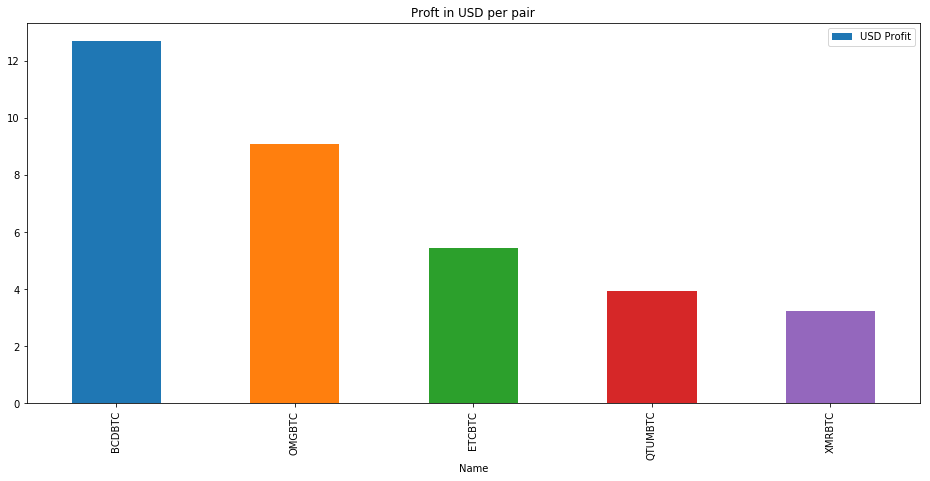

Name  USD Profit
 BCDBTC      $12.70
 OMGBTC       $9.07
 ETCBTC       $5.44
QTUMBTC       $3.93
 XMRBTC       $3.22


In [12]:
resultDf['USD Profit'] = (float(response.json()[0]['price_usd']) * resultDf['Profit'])
resultDf = resultDf.sort_values(by='USD Profit', ascending=False)
ax = resultDf.plot(x='Name', y='USD Profit', kind='bar', figsize=(16,7), title='Proft in USD per pair')
plt.show()
finalDf = pd.DataFrame(resultDf[['Name','USD Profit']], index=None)

print(finalDf.to_string(index=False))

In [13]:
import datetime as datetime
print('\n')
print ('Current Bitcoin Price as of ' + datetime.datetime.now().strftime('%I:%M %p on %B %d, %Y') + ' is: ' + "${:,.2f}".format(float(response.json()[0]['price_usd'])))
print('\n')



Current Bitcoin Price as of 05:33 PM on February 11, 2018 is: $8,351.63




In [14]:
feeCost = float(response2.json()[0]['price_usd']) * float(resultDf['Fee'].sum())
label = str('Profit from ' + str(start) + ' to ' + str(end) + ' in USD')
realTimeProfitDf.columns=[label]
print('\n')
print(str('Fee\'s from BNB ' + str(start) + ' to ' + str(end) + ' currently costs ' + "${:,.2f}".format(feeCost) + ' in USD.'))
print('\n')
realTimeProfitDf



Fee's from BNB 10:55 PM on February 10, 2018 to 10:24 PM on February 11, 2018 currently costs $0.71 in USD.




,"Profit from 10:55 PM on February 10, 2018 to 10:24 PM on February 11, 2018 in USD"
Total,$33.66


In [15]:
end = pd.to_datetime(df['Date'].iloc[0])
start = pd.to_datetime(df['Date'].iloc[-1])

diff = end - start

days, seconds = diff.days, diff.seconds
if days == 0:
    days = 1
hours = days * 24.0 + seconds // 3600.0
minutes = hours * 60.0

priceBTC = float(response.json()[0]['price_usd'])
avgProfMin = resultDf['Profit'].sum() * priceBTC / minutes
avgProfHour = resultDf['Profit'].sum() * priceBTC / hours
avgProfDay = resultDf['Profit'].sum() * (priceBTC / days)

btcProfit = resultDf['Profit'].sum()
print('Average profit per minute is ' "${:,.2f}".format(avgProfMin) + ' or ' + "{:,.15f}".format(btcProfit/minutes) + ' BTC.')
print('Average profit per hour is ' "${:,.2f}".format(avgProfHour) + ' or ' + "{:,.15f}".format(btcProfit/hours) + ' BTC.')
print('Average daily profit is ' "${:,.2f}".format(avgProfDay) + ' or ' + "{:,.15f}".format(btcProfit/days) + ' BTC.')

Average profit per minute is $0.01 or 0.000001459336033 BTC.
Average profit per hour is $0.73 or 0.000087560161977 BTC.
Average daily profit is $34.37 or 0.004115327612926 BTC.
Not bad for doing nothing!
